# Project

## 1. Imports

In [1]:
from nceiDatabaseConnector.nceiDatabasePackage.nceiDataManager import NCEIDataManager
from nceiDatabaseConnector.nceiDatabasePackage.nceiDatabaseManager import NCEIDatabaseManager

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 2. User settings

- years_in_db: An array of year Numbers that we want to download
- stations_file_path: the path where the stations data is stored and located
- modified_stations_file_path: the path where the modified stations data is stored
- download_csv_file_path: where the csv.gz files from the ncei file server should be saved
- modified_csv_file_path: where the modified csv files should be saved
- db_name: the name of the database you want to connect to
- db_user: the user that you want to connect with to the database
- db_password: the password for the user

In [2]:
years_in_db = [1950, 1951, 1952, 1953, 1954, 2010, 2011, 2012, 2013, 2014]
stations_file_path = "./data/stations/"
modified_stations_file_path = "./data/stations/modifiedStations/"
download_csv_file_path = "./data/NCEI/ghcn/daily/"
modified_csv_file_path = "./data/NCEI/modified/daily/"
db_name = "NCEIDatabase"
db_user = "ESDP"
db_password = "esdp1"
debug_messages = False
station_cols = ["id", "latitude", "longitude", "elevation", "state", "name", "gsn_flag", "hcn_crn_flag", "wmo_id"]
weather_cols = ["id", "stationcode", "datelabel", "param", "value", "mflag", "qflag", "sflag", "time"]

### 2.1 Docker setup

In [3]:
#This command writes the db_name, db_user and db_password to an env file which is used by the docker-container during postgresql setup
envVariables = {
    "DATABASE_NAME": db_name,
    "DATABASE_USER": db_user,
    "DATABASE_PASSWORD": db_password,
}

with open(".env", "w") as env_file:
    for key, value in envVariables.items():
        env_file.write(f"{key}={value}\n")

print(".env file created successfully.")

.env file created successfully.


#### Docker compose statements

In [4]:
#!docker-compose up -d --build
!docker-compose up -d

time="2024-07-18T01:33:48+02:00" level=warning msg="c:\\Users\\Fabi\\dev\\python\\ESDP1-Database-Project\\docker-compose.yml: `version` is obsolete"
 Container esdp1-database-project-db-1  Running


In [5]:
# run this to stop the docker container (but keep the data in the database for later)
# !docker-compose stop
# run this to stop and remove the docker container (you will loose all the data within the database and will have to set it up again)
#!docker-compose down

## 3. Create database manager

In [6]:
ncei_db = NCEIDatabaseManager(db_name=db_name, 
                         db_user=db_user, 
                         db_password=db_password, 
                         db_host="localhost", 
                         db_port="5432",
                         debug_messages = True,
                         years_in_db = years_in_db)

In [7]:
print(dir(ncei_db))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'check_year', 'connect_to_db', 'count_rows', 'create_climate_table', 'create_climate_tables', 'create_stations_table', 'db_host', 'db_name', 'db_password', 'db_port', 'db_user', 'debug_messages', 'drop_table', 'get_data_between_dates', 'get_data_between_dates_one_year', 'get_data_by_station_param', 'get_data_yearly', 'get_month_data', 'get_station_data', 'get_station_data_by_stationcode', 'insert_copy', 'is_valid_year', 'is_year_in_db', 'multi_threaded_insert', 'split_csv_file', 'station_cols', 'weather_cols', 'years_in_db']


## 4. Create data manager

In [8]:
ncei_data = NCEIDataManager()

In [9]:
print(dir(ncei_data))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'convert_stations', 'download_stations', 'download_year', 'download_years', 'export_downloaded_year', 'export_downloaded_years']


## 5. Download Data

### 5.1 Download Stations

In [10]:
ncei_data.download_stations(file_path_dest=stations_file_path)


Already downloaded station data.
Already downloaded station readme file.
Data (stations and readme) downloaded and saved in ./data/stations/


### 5.2 Download Climate data

In [11]:
ncei_data.download_years(array_of_years=years_in_db,
                         file_path=download_csv_file_path,
                         multi_thread=True, 
                         num_threads=4)

Already downloaded data for year 1950
Already downloaded data for year 1951
Already downloaded data for year 1952
Already downloaded data for year 1953
Already downloaded data for year 1954
Already downloaded data for year 2011
Already downloaded data for year 2012
Already downloaded data for year 2010
Already downloaded data for year 2013
Already downloaded data for year 2014


## 6. Export Filtered Data

In [12]:
ncei_data.export_downloaded_years(array_of_years=years_in_db, 
                                  file_path=download_csv_file_path, 
                                  file_path_dest=modified_csv_file_path, 
                                  multi_thread=True, 
                                  num_threads=4)

...Year 1950 processing...
Already exported data for year 1950.
...Year 1951 processing...
Already exported data for year 1951.
...Year 1952 processing...
...Year 1953 processing...
Already exported data for year 1952.
...Year 1954 processing...
Already exported data for year 1953.
Already exported data for year 1954.
...Year 2010 processing...
...Year 2011 processing...
...Year 2012 processing...
Already exported data for year 2010.
...Year 2013 processing...
Already exported data for year 2012.
Already exported data for year 2011.
Already exported data for year 2013.
...Year 2014 processing...
Already exported data for year 2014.


## 7. Fill Database

### 7.1 Stations

#### 7.1.1 Drop station table

In [13]:
# ncei_db.drop_table("Station")

#### 7.1.2 Create the stations table

##### Fehler hierbei
Error: connection to server at "localhost" (::1), port 5432 failed: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

In [14]:
ncei_db.create_stations_table()

Connected to database NCEIDatabase with user ESDP
Station table created.
Disconnected


#### 7.1.3 Insert the station into the database

In [15]:
file_path = f"{modified_stations_file_path}modified_stations.csv"

# ncei_db.insert_copy(file_path, "Station", station_cols)

#### 7.1.4 Verify the data insertion

In [16]:
ncei_db.count_rows("Station")

Connected to database NCEIDatabase with user ESDP
The table Station contains 127994 rows.
Disconnected


127994

### 7.2 Climate tables

#### 7.2.1 Drop table

In [17]:
# ncei_db.drop_table("Climate1950")

#### 7.2.3 Create all tables

In [18]:
ncei_db.create_climate_tables(years=years_in_db)

Connected to database NCEIDatabase with user ESDP
Table Climate1950 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate1951 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate1952 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate1953 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate1954 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate2010 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate2011 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate2012 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate2013 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
Table Climate2014 creat

True

#### 7.2.4 Verify the insertion of all tables

In [19]:
for year in years_in_db:
    ncei_db.count_rows(f"Climate{year}")

Connected to database NCEIDatabase with user ESDP
The table Climate1950 contains 18503793 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1951 contains 19279848 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1952 contains 19548958 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1953 contains 19831198 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1954 contains 20216183 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate2010 contains 27593925 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate2011 contains 26132221 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate2012 contains 26050070 rows.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate2013 contains 25090492 rows.
Disconnected
Connected to databa

#### 7.2.5 Insert the data into the database

In [20]:
for year in years_in_db:
    filePath = f"{modified_csv_file_path}modified_{year}.csv"

    table_name = ncei_db.create_climate_table(year=year)
    
    ncei_db.multi_threaded_insert(file_path=filePath, 
                                  table_name=table_name, 
                                  columns=weather_cols, 
                                  num_threads=4)

Connected to database NCEIDatabase with user ESDP
Table Climate1950 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1950 contains 18503793 rows.
Disconnected
Data in table Climate1950 already exists. Please check or delete the database before continuing.
Connected to database NCEIDatabase with user ESDP
Table Climate1951 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1951 contains 19279848 rows.
Disconnected
Data in table Climate1951 already exists. Please check or delete the database before continuing.
Connected to database NCEIDatabase with user ESDP
Table Climate1952 created successfully.
Disconnected
Connected to database NCEIDatabase with user ESDP
The table Climate1952 contains 19548958 rows.
Disconnected
Data in table Climate1952 already exists. Please check or delete the database before continuing.
Connected to database NCEIDatabase with user ESDP
Table Climate1953 creat

## 8. Get Data

We want to compare different parameters for the years 1950-1955 and 2010-2015.  
We have the parameters TMIN, TMAX, PRCP etc.

1. Create lineplot for a daterange (one year or days of different years)
2. Boxplot

- SELECT COUNT(*) AS count, stationcode FROM "Climate1950" GROUP BY stationcode ORDER BY count DESC LIMIT 1;
- Result: AUW00034165
- SELECT COUNT(*) AS count, stationcode FROM "Climate2010" GROUP BY stationcode ORDER BY count DESC LIMIT 1;
- Result: AQW00061705

hat nicht gut geklappt

versucht, die am meisten da waren mit normalem Count

CA001012040 und CA001016940



### 8.1 Station data

In [21]:
stations_data = ncei_db.get_station_data(columns=station_cols)
stations_data.head()

Connected to database NCEIDatabase with user ESDP

                    SELECT "id", "latitude", "longitude", "elevation", "state", "name", "gsn_flag", "hcn_crn_flag", "wmo_id" 
                    FROM "Station"               
            
The requested query returned 127994 results.
Alles gucci bis her


,id,latitude,longitude,elevation,state,name,gsn_flag,hcn_crn_flag,wmo_id
0,ACW00011604,17.1167,-61.7833,10.1,None,ST JOHNS COOLIDGE FLD,None,None,None
1,ACW00011647,17.1333,-61.7833,19.2,None,ST JOHNS,None,None,None
2,AE000041196,25.3330,55.5170,34.0,None,SHARJAH INTER. AIRP,GSN,None,41196
3,AEM00041194,25.2550,55.3640,10.4,None,DUBAI INTL,None,None,41194
4,AEM00041217,24.4330,54.6510,26.8,None,ABU DHABI INTL,None,None,41217


In [22]:
def get_station_by_stationcode(stationcode):
    return stations_data[stations_data["id"] == stationcode]

#### 8.1.1 Settings

In [23]:
start_date_plotting = "1954-01-01"
end_date_plotting = "2010-12-31"
parameters = ["PRCP"]
# stations = ["AQW00061705", "AUW00034165"]
stations = ["CA001012040", "CA001016940", "ASN00008051", "CHM00055279"]
columns = ["stationcode", "datelabel", "value", "param"]

years_for_plotting = [1950, 2012, 2014]

month = 12

In [24]:
for station in stations:
    print(get_station_by_stationcode(station).values[0])

['CA001012040' 48.8167 -124.1333 177.0 'BC' 'COWICHAN LAKE FORESTRY' None
 None None]
['CA001016940' 48.6167 -123.4167 61.0 'BC' 'SAANICHTON CDA' None None None]
['ASN00008051' -28.7953 114.6975 33.0 None 'GERALDTON AIRPORT' 'GSN' None
 '94403']
['CHM00055279' 31.367 90.017 4701.0 None 'BAINGOIN' None None '55279']


### 8.2 Climate data

#### 8.2.2 Get data for lineplot

In [25]:
yearly_data_for_lineplot = ncei_db.get_data_yearly(years=years_for_plotting, 
                                                   parameters=parameters, 
                                                   stations=stations, 
                                                   columns=columns)



Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP')
                    ORDER BY datelabel                
            
The requested query returned 1095 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP')
                    ORDER BY datelabel                
            
The requested query returned 1202 results.
Co

In [26]:
print(yearly_data_for_lineplot.head())
print(yearly_data_for_lineplot.info())

   stationcode   datelabel     value param
0  CA001016940  1950-01-01  2.300000  PRCP
1  CA001012040  1950-01-01  8.900001  PRCP
2  ASN00008051  1950-01-01  0.000000  PRCP
3  CA001016940  1950-01-02  5.300000  PRCP
4  CA001012040  1950-01-02  0.000000  PRCP
<class 'pandas.core.frame.DataFrame'>
Index: 3437 entries, 0 to 1139
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   stationcode  3437 non-null   object 
 1   datelabel    3437 non-null   object 
 2   value        3437 non-null   float64
 3   param        3437 non-null   object 
dtypes: float64(1), object(3)
memory usage: 134.3+ KB
None


#### 8.2.3 Get data for boxplots

In [27]:
for year in years_for_plotting:
    monthly_data = ncei_db.get_month_data(year, month, parameters, stations, columns=columns)

    print(monthly_data.head())
    print(monthly_data.info())

Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 93 results.
   stationcode   datelabel      value param
0  ASN00008051  1950-12-01   0.000000  PRCP
1  CA001012040  1950-12-01   3.800000  PRCP
2  CA001016940  1950-12-01   1.000000  PRCP
3  CA001012040  1950-12-02  11.400001  PRCP
4  CA001016940  1950-12-02   3.600000  PRCP
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   stationcode  93 non-null     object 
 1   datelabel    9

## 9. Plot Data

### 9.1 Task 1 (Lineplot)

#### 9.1.1 Functions for plotting

In [28]:
def create_linepplot_years(years, stations, parameters, columns = ["stationcode", "datelabel", "value", "param"]):
    yearly_data = ncei_db.get_data_yearly(years, parameters, stations, columns)

    # Convert datelabel to datetime format
    yearly_data["datelabel"] = pd.to_datetime(yearly_data["datelabel"])

    for station in stations:
        station_filtered_data = yearly_data[(yearly_data["stationcode"] == station)].copy()

        station_name = get_station_by_stationcode(station)["name"].values[0]

        for parameter in parameters:
            plt.figure(figsize=(14, 8)) 

            parameter_filtered_data = station_filtered_data[(station_filtered_data["param"] == parameter)].copy()

            filtered_years = [year for year in years if ncei_db.check_year(year)]

            for year in filtered_years:
                filtered_data = parameter_filtered_data[(parameter_filtered_data["datelabel"].dt.year == year)].copy()

                if filtered_data.empty:
                    print("Empty")
                    continue

                filtered_data.loc[:, "day"] = filtered_data.loc[:, "datelabel"].dt.strftime("%m-%d")

                sns.lineplot(x="day", y="value", style=year, data=filtered_data, errorbar=("ci", 1))

                

            month_labels = [f"{i:02d}-01" for i in range(1, 13)]
            plt.xticks(ticks=month_labels, labels=pd.to_datetime(month_labels, format="%m-%d").strftime("%b"))
            plt.ylim(parameter_filtered_data["value"].min()-5, parameter_filtered_data["value"].max()+5)
            plt.title(f"Yearly comparison of parameter: {parameter} at station: {station_name}")
            plt.xlabel("Date")
            plt.ylabel(f"{parameter}")
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()

In [29]:
def create_boxplot_monthly_comparison(years, month, stations, parameters, columns = ["stationcode", "datelabel", "value", "param"]):
    for station in stations:
        fig, axes = plt.subplots(len(parameters), len(years), figsize=(15, 10), sharey="row")

        station_name = get_station_by_stationcode(station)["name"].values[0]
        
        if len(parameters) == 1:
            axes = np.array([axes])

        for i, parameter in enumerate(parameters):
            for j, year in enumerate(years):
                ax = axes[i, j]

                monthly_data = ncei_db.get_month_data(year, month, parameters=[parameter], stations=[station], columns=columns)

                if not monthly_data.empty:
                    sns.boxplot(x="stationcode", y="value", data=monthly_data, ax=ax, hue="param", dodge=True)

                    # Set plot labels and title
                    ax.set_title(f"{parameter} | {year}-{month} | {len(monthly_data)} values in DB")
                    ax.set_xlabel("Station Code")
                    ax.set_ylabel(f"Value of parameter {parameter}")
                    ax.set_ylim(monthly_data["value"].min()-2, monthly_data["value"].max()+2)
                    ax.grid()

        plt.suptitle(f"Comparison of station {station_name} through multiple years.")
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.96])  

        # Show plot
        plt.show()



#### 9.1.2 Plot the data

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP')
                    ORDER BY datelabel                
            
The requested query returned 1095 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('CA001012040','CA001016940','ASN00008051','CHM00055279') AND 
                            param IN ('PRCP')
                    ORDER BY datelabel                
            
The requested query returned 1202 results.
Co

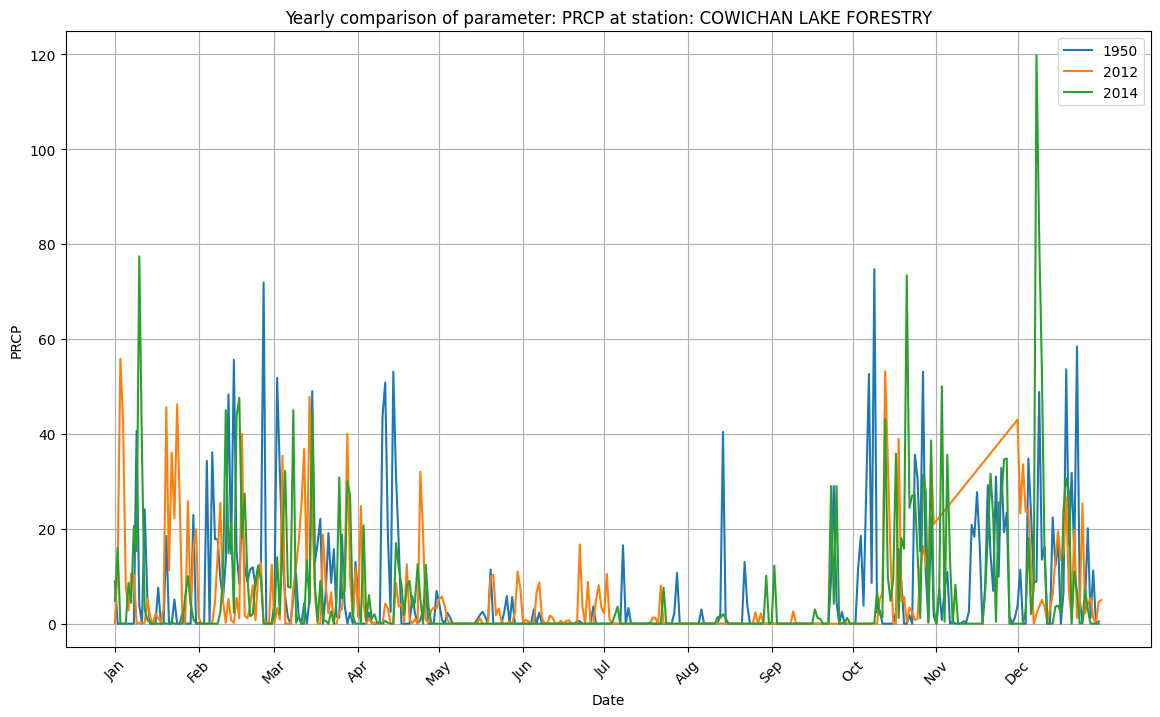

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP


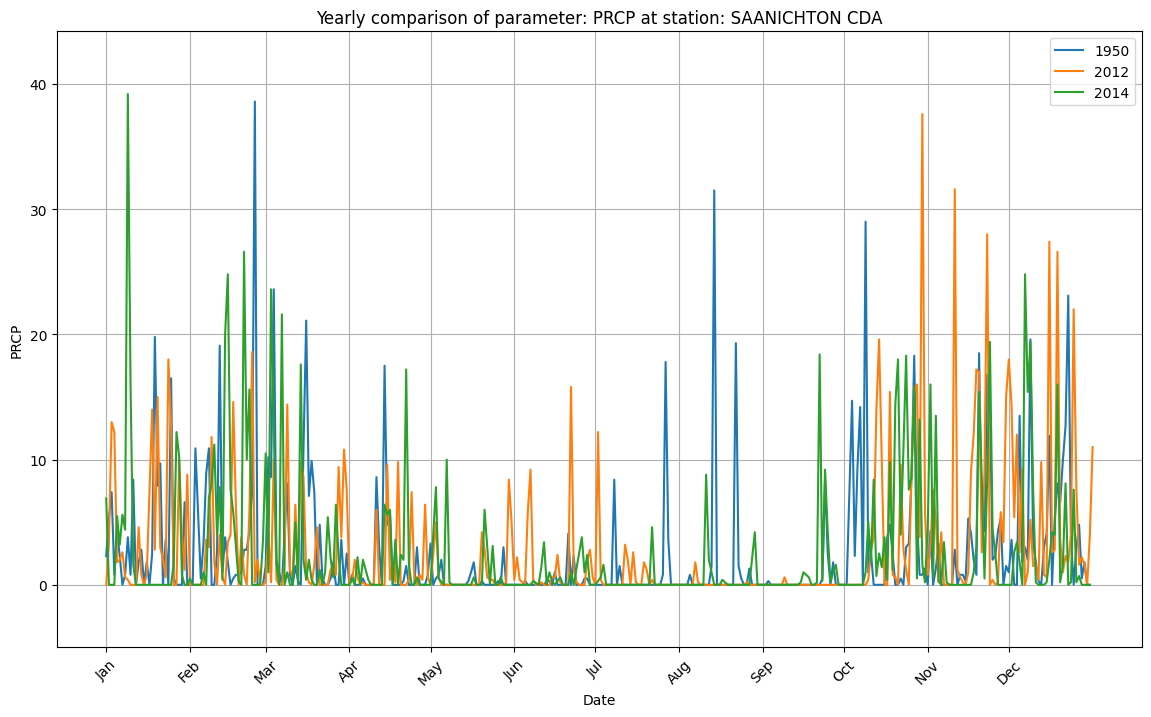

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP


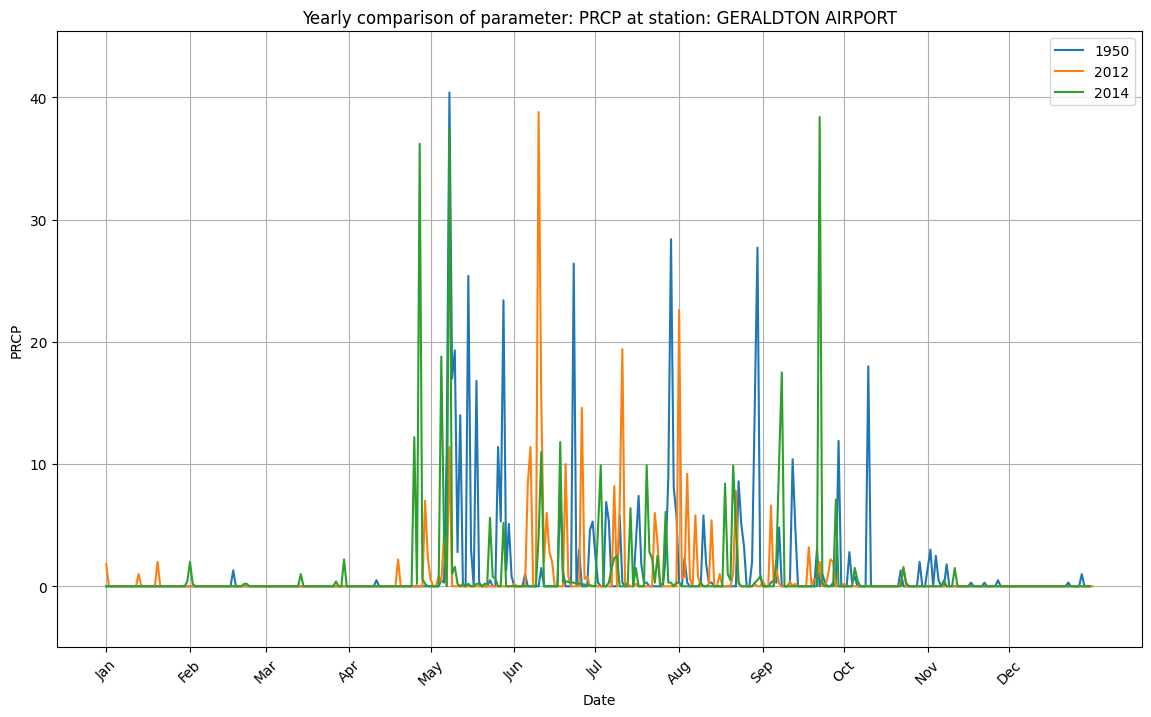

Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Connected to database NCEIDatabase with user ESDP
Empty


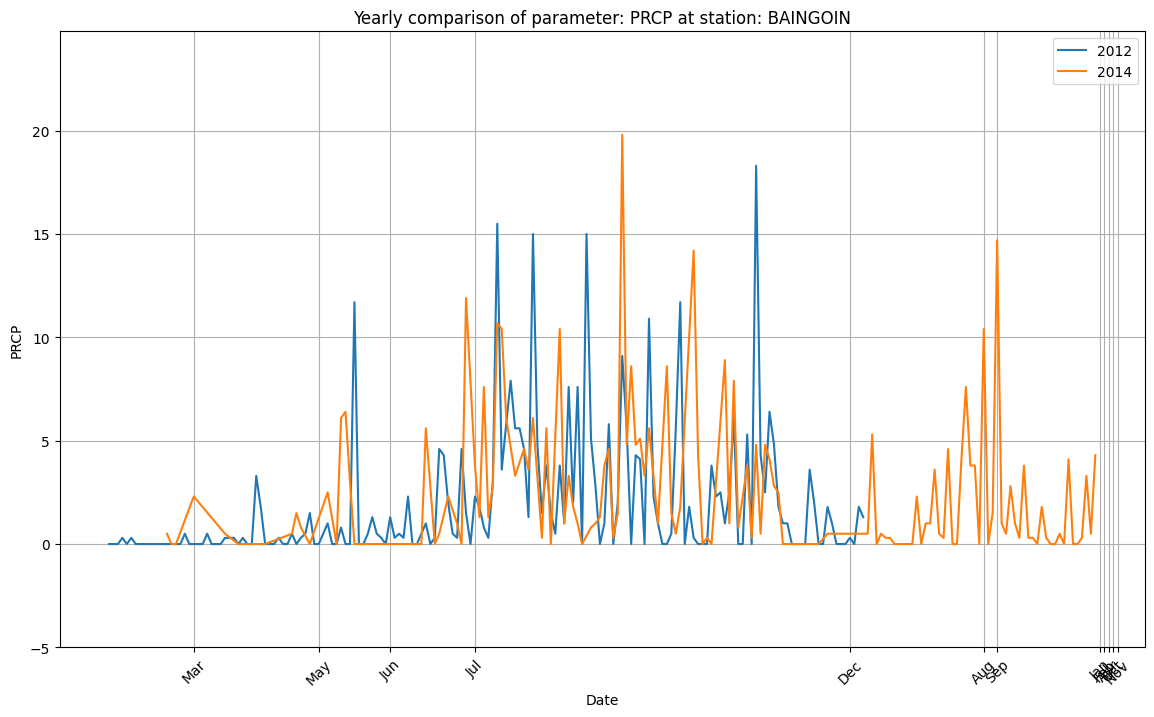

In [30]:
# stations = ["CHM00055279"]
create_linepplot_years(years_for_plotting, stations, parameters)

#### 9.1.3 Plot Monthly difference

Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001012040') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 31 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('CA001012040') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 29 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", 

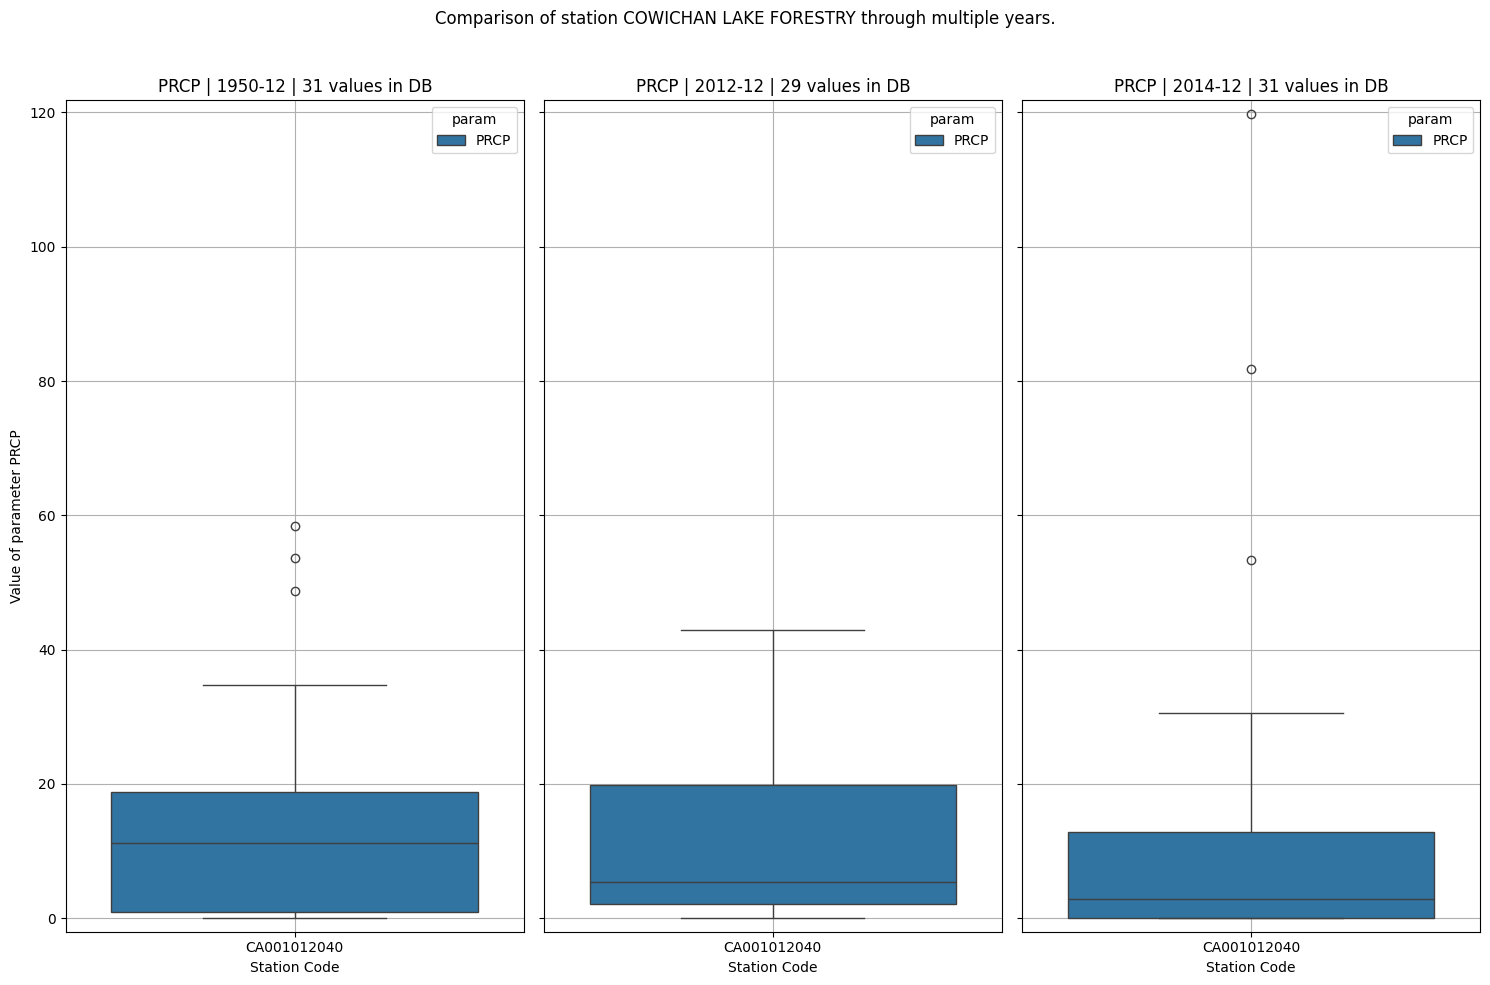

Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CA001016940') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 31 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('CA001016940') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 31 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", 

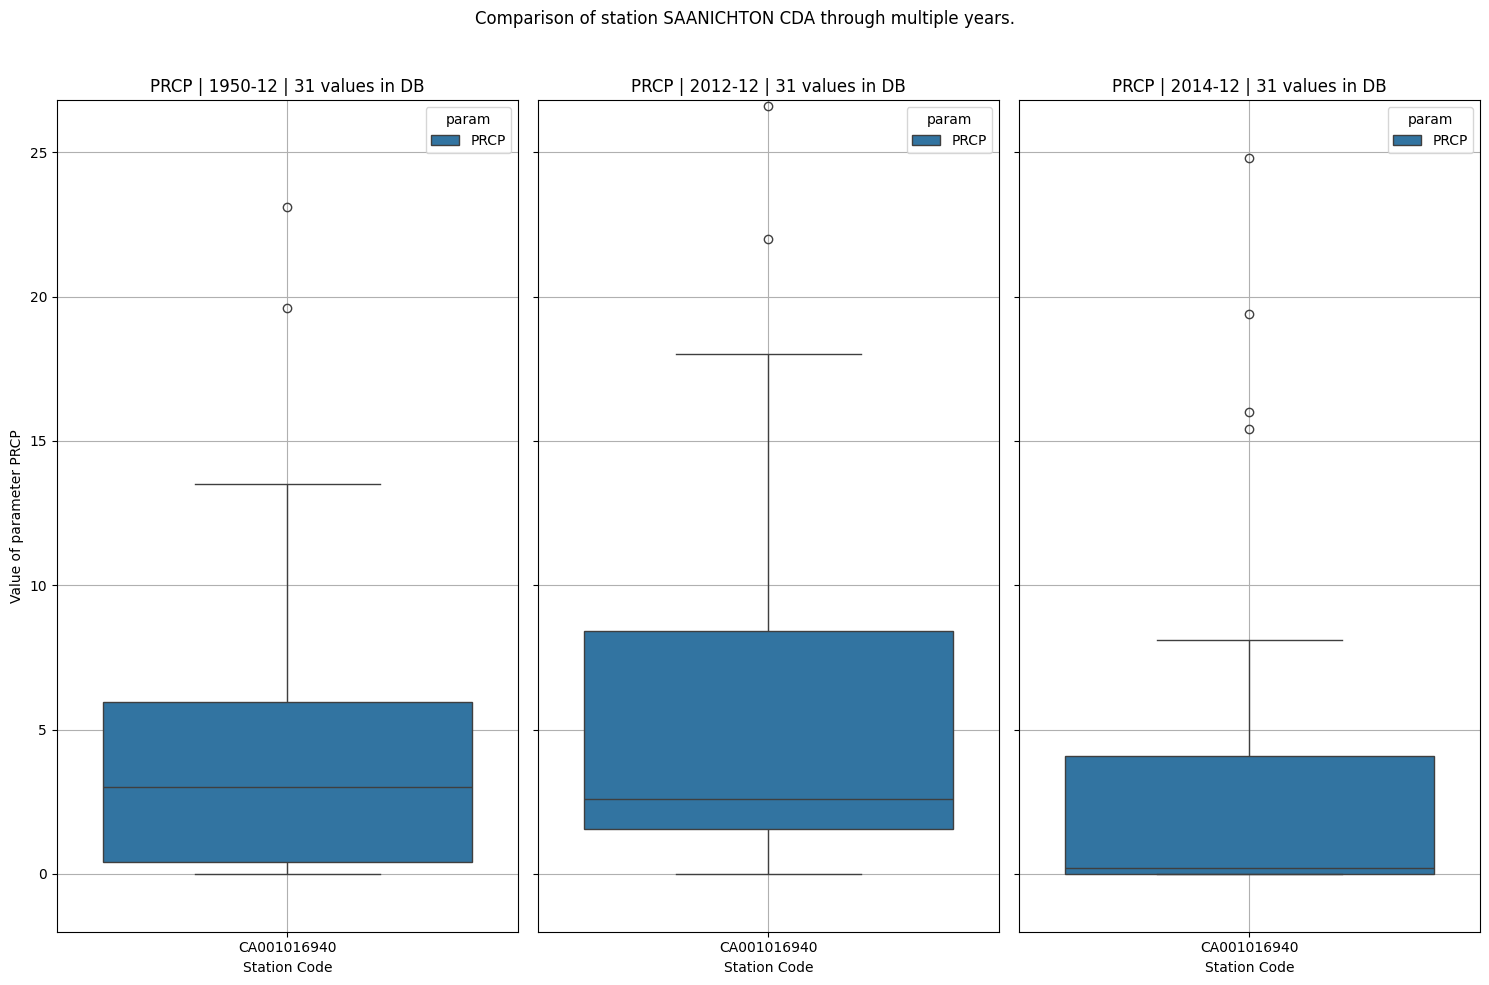

Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('ASN00008051') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 31 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('ASN00008051') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 31 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", 

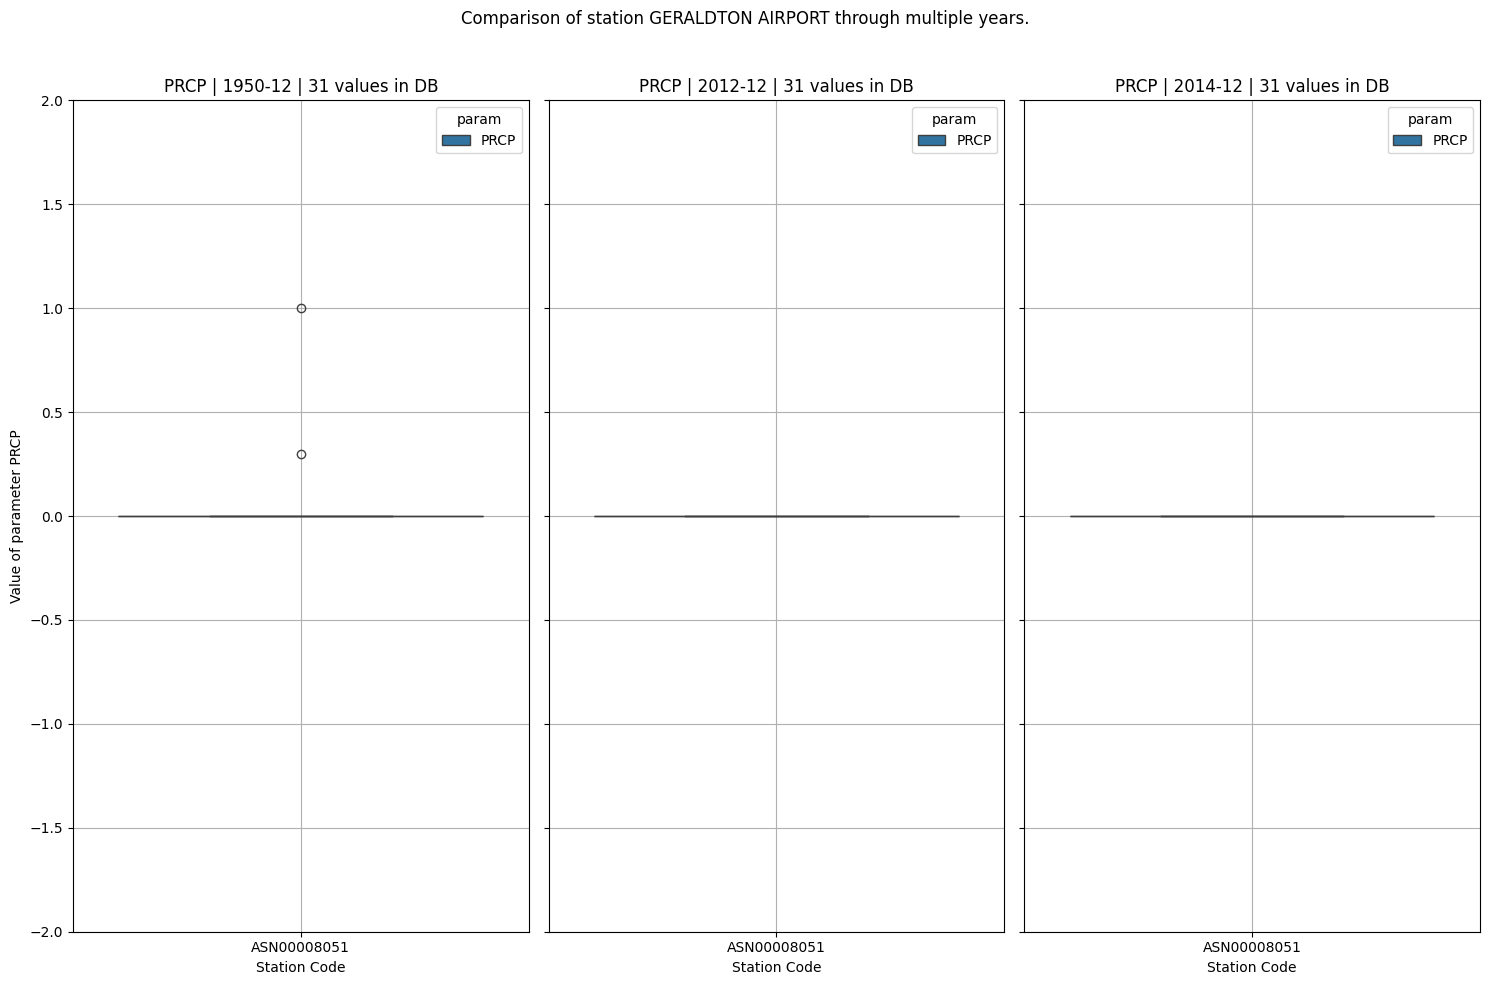

Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate1950"
                    WHERE stationcode IN ('CHM00055279') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 0 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "value", "param" 
                    FROM "Climate2012"
                    WHERE stationcode IN ('CHM00055279') AND 
                            param IN ('PRCP') AND
                            date_part('month', datelabel) = 12
                    ORDER BY datelabel                
            
The requested query returned 4 results.
Connected to database NCEIDatabase with user ESDP

                    SELECT "stationcode", "datelabel", "v

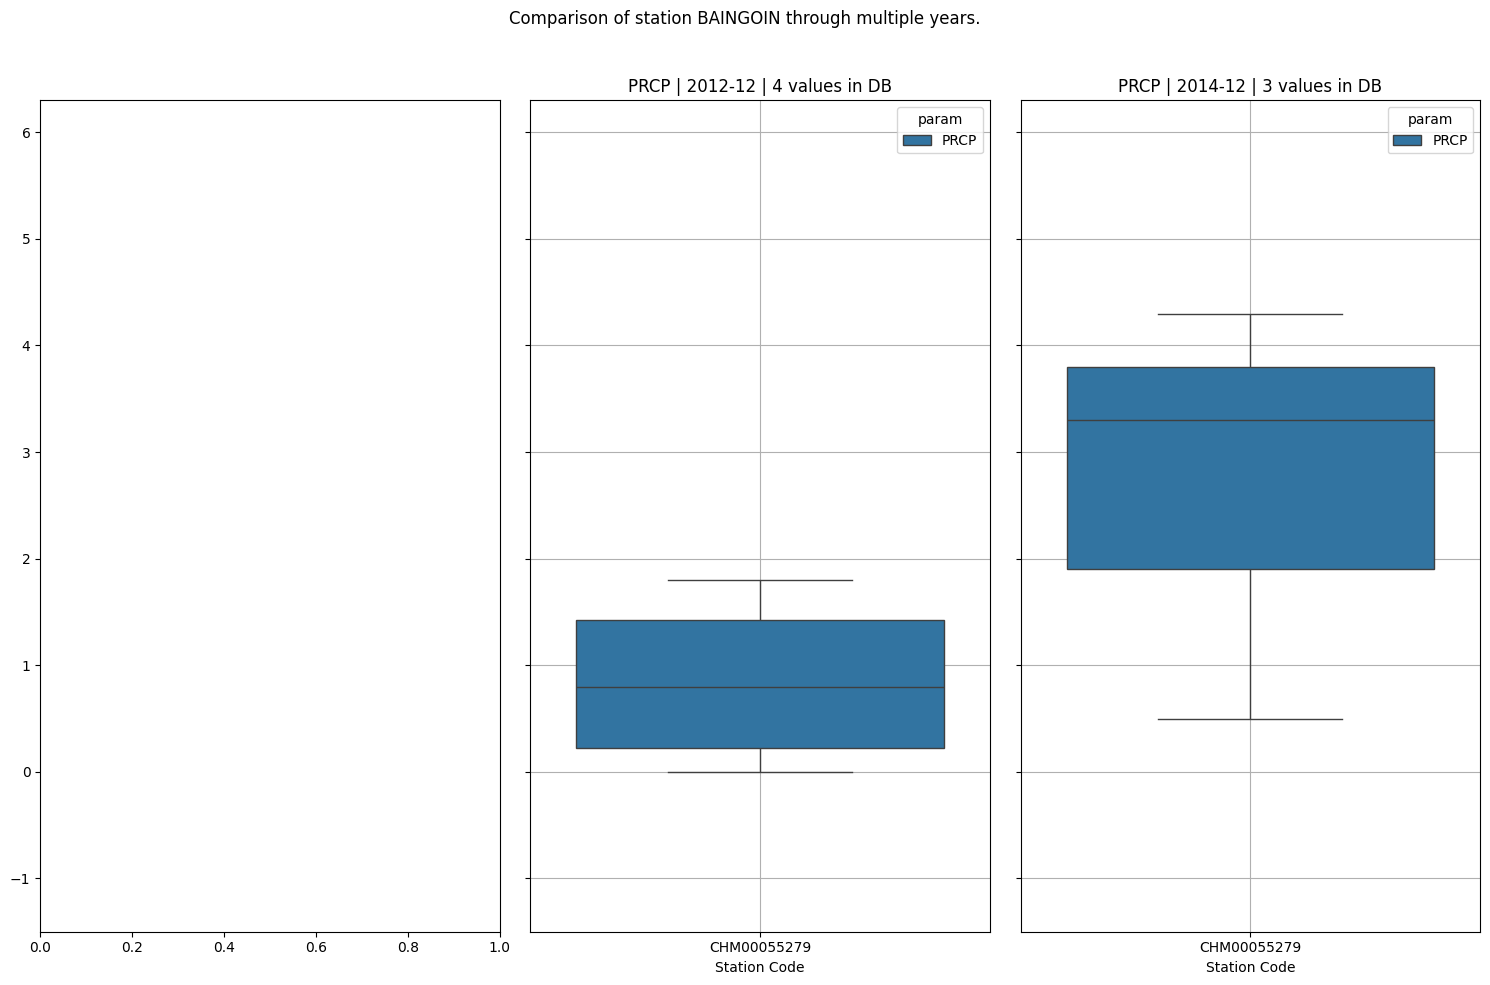

In [31]:
create_boxplot_monthly_comparison(years_for_plotting, month, stations, parameters)